## Load models, season data, and set paths

- Goal: bring in saved models and season data we'll use for reliability.
- We load the RandomForest regressor (finish position) and classifier (top-10), plus the season table for context.
- This gives us reliability stats (DNF rates) and the feature list we need to match for simulation.

In [2]:
from pathlib import Path
import numpy as np, pandas as pd
from joblib import load

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED = ROOT / "data" / "processed"
MODELS = ROOT / "models"

# Load trained models (from Phase 3)
reg_pipe = load(MODELS / "rf_finishpos.joblib")
cls_pipe = load(MODELS / "rf_top10.joblib")

# Season-wide features (for reliability and feature alignment)
season = pd.read_csv(PROCESSED / "season_2025_features_enriched.csv")
season["event_date"] = pd.to_datetime(season["event_date"], errors="coerce")

print("Loaded models and season table:", season.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\maxnd\\Documents\\Machine Learning\\f1-race-predictor\\data\\processed\\season_2025_features_enriched.csv'

## Choose a weekend and assemble the feature matrix

- Goal: pick a race weekend and construct the model's feature matrix for its drivers.
- We reconstruct the training feature list from the season table and apply it to this weekend.
- Missing columns are allowed—our model pipeline imputes them.

In [ ]:
YEAR, ROUND = 2025, 16   # You can change this later (e.g., latest round)

# Load the weekend features we prepared in Phase 1 (+targets there, but we won't use targets now)
wk = pd.read_csv(PROCESSED / f"features_weekend_ext_target_{YEAR}_R{ROUND}.csv")

# Build the same feature set used during training (recompute the list from the season file)
candidate = [
    "fp_mean_all_s","fp_median_longrun_s","fp_total_laps",
    "qual_pos","delta_to_pole_s","grid_pos","grid_drop",
    "pitstops","avg_stint_len","stint_count","mean_race_pace_s",
    "stints_soft","stints_medium","stints_hard",
    "roll3_avg_pos","roll5_avg_pos","roll3_pts","roll5_pts","roll5_dnf_rate",
    "team_roll3_pts","team_roll5_pts","track_hist_avg_pos",
]

# Features present in season data
feat_season = [c for c in candidate if c in season.columns]
# Drop all-NaN and constant columns (based on season)
feat_season = [c for c in feat_season if not season[c].isna().all()]
feat_season = [c for c in feat_season if season[c].nunique(dropna=True) > 1]

# Build weekend matrix with the same columns (add missing as NaN, keep order)
Xw = wk.reindex(columns=feat_season)
drivers = wk["Driver"].tolist()
teams = wk["TeamName"] if "TeamName" in wk.columns else pd.Series(["?"]*len(drivers))
grid = wk["grid_pos"] if "grid_pos" in wk.columns else pd.Series([np.nan]*len(drivers))

print("Weekend:", YEAR, ROUND, "| drivers:", len(drivers), "| features used:", len(feat_season))
Xw.head()


Weekend: 2023 1 | drivers: 20 | features used: 12


,fp_mean_all_s,fp_median_longrun_s,fp_total_laps,qual_pos,delta_to_pole_s,grid_pos,roll3_avg_pos,roll5_avg_pos,roll3_pts,roll5_pts,team_roll3_pts,team_roll5_pts
0,105.757354,107.039500,34,1.0,0.000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,99.003498,97.001500,33,2.0,0.138,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,98.779311,98.049500,31,3.0,0.292,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,104.046539,99.281333,41,4.0,0.446,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,109.358783,98.643000,38,5.0,0.628,5.0,NaN,NaN,NaN,NaN,NaN,NaN


## Sync feature list with the saved model

- Goal: rebuild the training feature list exactly as in modeling (drop all-NaN & constants).
- We reconstruct the exact feature set used in modeling (same drop rules), then reindex the weekend to match.
- This keeps the column count and order consistent with the saved pipeline.

In [ ]:
import numpy as np

candidate = [
    "fp_mean_all_s","fp_median_longrun_s","fp_total_laps",
    "qual_pos","delta_to_pole_s","grid_pos","grid_drop",
    "pitstops","avg_stint_len","stint_count","mean_race_pace_s",
    "stints_soft","stints_medium","stints_hard",
    "roll3_avg_pos","roll5_avg_pos","roll3_pts","roll5_pts","roll5_dnf_rate",
    "team_roll3_pts","team_roll5_pts","track_hist_avg_pos",
]

# Step 1: columns present in season table
features = [c for c in candidate if c in season.columns]

# Step 2: drop ±inf → NaN, then remove all-NaN and constant columns (identical to modeling FIX-M2)
Xseason_raw = season[features].replace([np.inf, -np.inf], np.nan).copy()
all_nan_cols = Xseason_raw.columns[Xseason_raw.isna().all()]
Xseason = Xseason_raw.drop(columns=list(all_nan_cols))
const_cols = [c for c in Xseason.columns if Xseason[c].nunique(dropna=True) <= 1]
Xseason = Xseason.drop(columns=const_cols)

features_clean = Xseason.columns.tolist()
print("Training feature list rebuilt:", len(features_clean), "features")

# Reindex weekend matrix to the same features (order matters)
Xw = wk.reindex(columns=features_clean)
print("Weekend Xw shape:", Xw.shape)

Training feature list rebuilt: 12 features
Weekend Xw shape: (20, 12)


## Derived columns used in training

- Goal: ensure derived features match training (esp. grid_drop).
- Your model expects grid_drop; we compute it for both the season table and the chosen weekend.
- Now the feature names will match what the pipeline saw during training.

In [ ]:
# Goal: add any derived columns the model expects (especially grid_drop).
# Why: your saved pipeline was trained with these; we must recreate them.

import numpy as np
import pandas as pd

# Add grid_drop to SEASON and WEEKEND if missing
if "grid_drop" not in season.columns and {"grid_pos","qual_pos"}.issubset(season.columns):
    season["grid_drop"] = pd.to_numeric(season["grid_pos"], errors="coerce") - pd.to_numeric(season["qual_pos"], errors="coerce")
if "grid_drop" not in wk.columns and {"grid_pos","qual_pos"}.issubset(wk.columns):
    wk["grid_drop"] = pd.to_numeric(wk["grid_pos"], errors="coerce") - pd.to_numeric(wk["qual_pos"], errors="coerce")

# Keep these numeric
for df_ in (season, wk):
    for c in ["grid_pos","qual_pos","grid_drop"]:
        if c in df_.columns:
            df_[c] = pd.to_numeric(df_[c], errors="coerce")

print("Derived columns aligned (grid_drop ensured).")

Derived columns aligned (grid_drop ensured).


## Lock features to the model’s feature list

- Goal: use the saved model's exact feature names & order for BOTH season and weekend matrices.
- Why: the pipeline's SimpleImputer was fit with these names; predict() requires an identical set/order.

In [ ]:
# Goal: reindex SEASON & WEEKEND to the exact feature names/order the pipeline was fitted with.
# Why: the pipeline's SimpleImputer stores feature_names_in_; predict() requires a perfect match.

# Preferred: read the list from the saved pipeline
try:
    features_model = list(reg_pipe.named_steps["imp"].feature_names_in_)
except Exception:
    # Fallback: intersect a standard candidate list with season columns
    candidate = [
        "fp_mean_all_s","fp_median_longrun_s","fp_total_laps",
        "qual_pos","delta_to_pole_s","grid_pos","grid_drop",
        "pitstops","avg_stint_len","stint_count","mean_race_pace_s",
        "stints_soft","stints_medium","stints_hard",
        "roll3_avg_pos","roll5_avg_pos","roll3_pts","roll5_pts","roll5_dnf_rate",
        "team_roll3_pts","team_roll5_pts","track_hist_avg_pos",
    ]
    features_model = [c for c in candidate if c in season.columns]

print("Model expects", len(features_model), "features.")
Xw           = wk.reindex(columns=features_model)
X_season_df  = season.reindex(columns=features_model)

missing_w = [c for c in features_model if c not in wk.columns]
missing_s = [c for c in features_model if c not in season.columns]
print("Missing in weekend (imputed as NaN):", missing_w)
print("Missing in season  (imputed as NaN):", missing_s)
print("Shapes — weekend:", Xw.shape, "| season:", X_season_df.shape)

Model expects 13 features.
Missing in weekend (imputed as NaN): ['roll3_avg_pos', 'roll5_avg_pos', 'roll3_pts', 'roll5_pts', 'team_roll3_pts', 'team_roll5_pts']
Missing in season  (imputed as NaN): []
Shapes — weekend: (20, 13) | season: (200, 13)


## Reliability & noise: DNF rates + residual sigma

- Goal: compute per-driver DNF probability and sigma (use the saved pipeline directly).
- We blend driver + team DNF rates from the season to get a robust per-driver DNF probability.
- We estimate uncertainty σ from model residuals (convert MAE → σ assuming Normal errors).

In [ ]:
# Goal: compute per-driver DNF probabilities and simulation noise (sigma).
# Why: DNFs add realism; sigma comes from in-sample residual MAE (pipeline imputes internally).

# DNF flag if missing
if "dnf" not in season.columns:
    def is_dnf_row(row):
        st = str(row.get("Status","")).lower()
        pos = row.get("finish_pos", np.nan)
        pts = row.get("points", 0.0)
        return (("finished" not in st) and ("classified" not in st) and (pd.isna(pos) or pos > 20)) or (pd.isna(pos) and pts==0)
    season["dnf"] = season.apply(is_dnf_row, axis=1).astype(int)

driver_dnf = season.groupby("Driver")["dnf"].mean()
team_dnf   = season.groupby("TeamName")["dnf"].mean()

p_dnf = []
for d, t in zip(drivers, teams):
    p = 0.5*driver_dnf.get(d, np.nan) + 0.5*team_dnf.get(t, np.nan)
    if np.isnan(p):
        p = float(driver_dnf.mean()) if not np.isnan(driver_dnf.mean()) else 0.07
    p_dnf.append(float(np.clip(p, 0.01, 0.30)))
p_dnf = np.array(p_dnf)

# Sigma from in-sample residuals of the saved regressor (no manual imputation here)
y_season   = season["finish_pos"].astype(float).values
pred_season= reg_pipe.predict(X_season_df)   # pipeline handles impute/scale
mae_train  = float(np.mean(np.abs(y_season - pred_season)))
sigma      = float(mae_train / 0.798)        # MAE ≈ σ * sqrt(2/pi)

print(f"DNF mean: {p_dnf.mean():.3f} | sigma (positions): {sigma:.2f}")

DNF mean: 0.010 | sigma (positions): 1.30


## Monte Carlo simulator (simple, defensible)

- Goal: simulate N races, adding noise, grid inertia, safety-car variance, and DNFs.
- We simulate 1,000 races with noise, grid inertia, a safety-car variance toggle, and DNFs.
- Outputs: expected finishing position, win/podium/top-10 probabilities, and expected points.

In [ ]:
# Goal: simulate N races with noise, grid pull, safety-car variance, and DNFs.
# Why: gives distributions (win/podium/top10) + expected finishing order and points.

import numpy as np
import pandas as pd

def points_from_pos(p):
    table = {1:25,2:18,3:15,4:12,5:10,6:8,7:6,8:4,9:2,10:1}
    return table.get(int(p), 0)

def simulate_weekend(Xw, drivers, grid, reg_pipe, cls_pipe, p_dnf, sigma,
                     N=1000, grid_bias=0.30, sc_prob=0.35, sc_scale=1.25, seed=42):
    m = len(drivers)
    y_hat  = reg_pipe.predict(Xw)               # base position estimate
    p_pts  = cls_pipe.predict_proba(Xw)[:, 1]   # top10 probability (reference)
    grid_v = grid.values if isinstance(grid, pd.Series) else np.array(grid)
    base   = y_hat if np.all(np.isnan(grid_v)) else (y_hat + grid_bias*(grid_v - y_hat))

    sims = np.zeros((N, m), dtype=int)
    rng  = np.random.default_rng(seed)
    for s in range(N):
        scf   = sc_scale if rng.random() < sc_prob else 1.0
        noise = rng.normal(0, sigma*scf, size=m)
        score = base + noise
        dnf   = rng.random(m) < p_dnf
        alive = np.where(~dnf)[0]; dnf_i = np.where(dnf)[0]
        order_alive = alive[np.argsort(score[alive], kind="mergesort")]
        pos = np.empty(m, dtype=int)
        pos[order_alive] = np.arange(1, len(order_alive)+1)
        pos[dnf_i[np.argsort(score[dnf_i], kind="mergesort")]] = np.arange(len(order_alive)+1, m+1)
        sims[s] = pos

    pos_mean = sims.mean(axis=0)
    out = pd.DataFrame({
        "Driver": drivers,
        "grid_pos": grid.values if isinstance(grid, pd.Series) else grid,
        "pred_base_pos": np.round(y_hat, 2),
        "exp_pos": np.round(pos_mean, 2),
        "p_win": (sims==1).mean(axis=0),
        "p_podium": (sims<=3).mean(axis=0),
        "p_top10_sim": (sims<=10).mean(axis=0),
        "p_top10_cls": np.round(p_pts, 3),
        "exp_points": np.apply_along_axis(lambda col: np.mean([points_from_pos(p) for p in col]), 0, sims),
    }).sort_values(["exp_pos","pred_base_pos"]).reset_index(drop=True)

    for c in ["p_win","p_podium","p_top10_sim"]:
        out[c] = out[c].round(3)
    out["exp_points"] = out["exp_points"].round(2)
    return out, sims

N = 1000
sim_table, sims_pos = simulate_weekend(Xw, drivers, grid, reg_pipe, cls_pipe, p_dnf, sigma, N=N)
print("Sim table:", sim_table.shape, "| sims matrix:", sims_pos.shape)
sim_table.head(12)


Sim table: (20, 9) | sims matrix: (1000, 20)


,Driver,grid_pos,pred_base_pos,exp_pos,p_win,p_podium,p_top10_sim,p_top10_cls,exp_points
0,VER,1.0,7.80,2.84,0.347,0.734,0.989,0.773,17.56
1,PER,2.0,7.79,3.23,0.252,0.651,0.987,0.772,16.15
2,LEC,3.0,7.95,3.85,0.167,0.532,0.983,0.785,14.33
3,SAI,4.0,8.28,4.63,0.087,0.374,0.980,0.781,12.05
4,ALO,5.0,8.46,5.23,0.068,0.269,0.968,0.799,10.63
5,RUS,6.0,8.51,5.70,0.045,0.218,0.954,0.820,9.56
6,HAM,7.0,8.60,6.40,0.027,0.152,0.934,0.821,8.04
7,STR,8.0,9.86,8.59,0.004,0.028,0.779,0.743,4.12
8,OCO,9.0,10.19,9.63,0.001,0.018,0.663,0.656,2.88
9,HUL,10.0,10.17,10.12,0.001,0.018,0.573,0.646,2.45


## Visuals: expected position + a distribution view

- Goal: quick visuals — expected position bar + a distribution (top 8 drivers).
- First plot shows expected finish positions per driver.
- Second overlays finish distributions for the top 8 to show uncertainty.

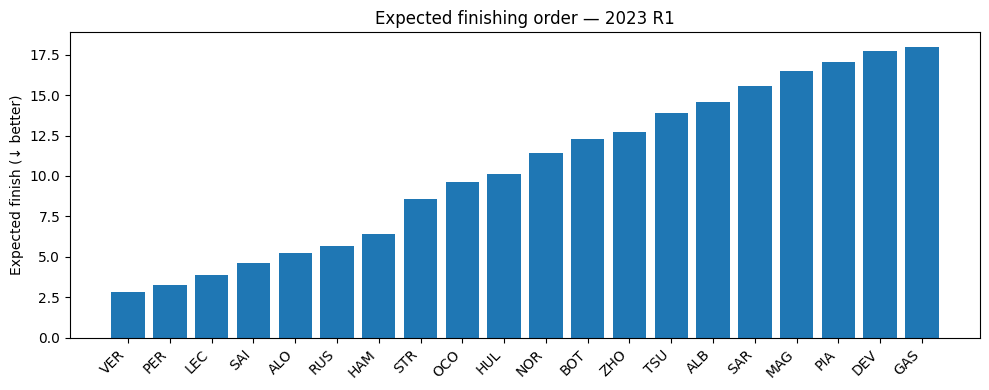

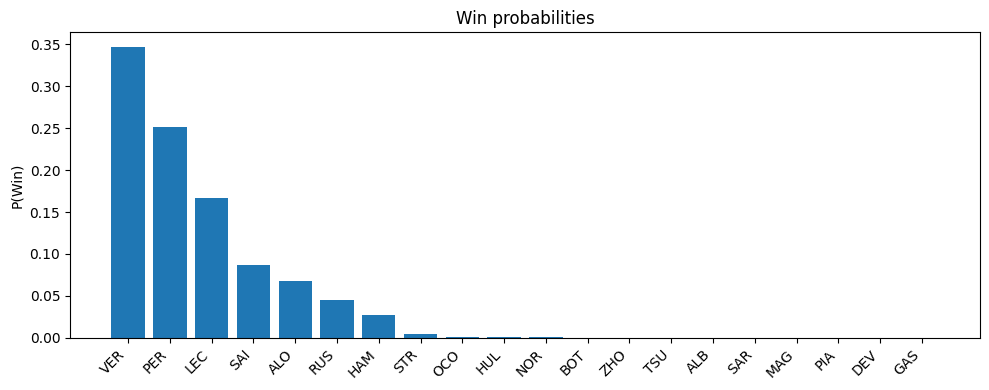

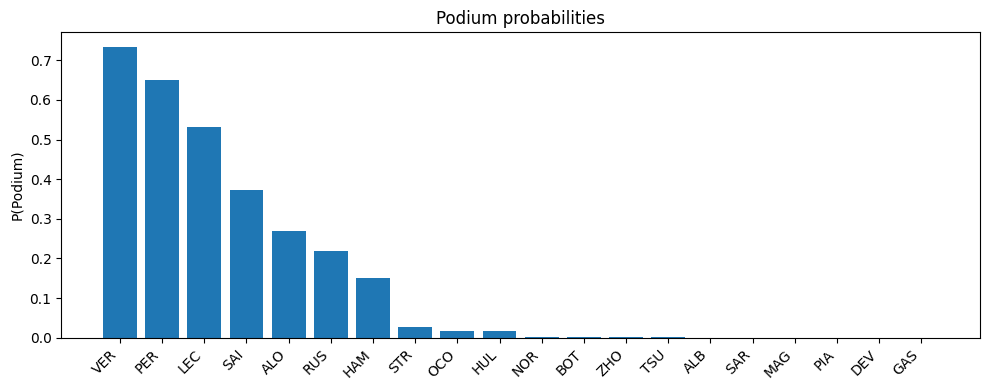

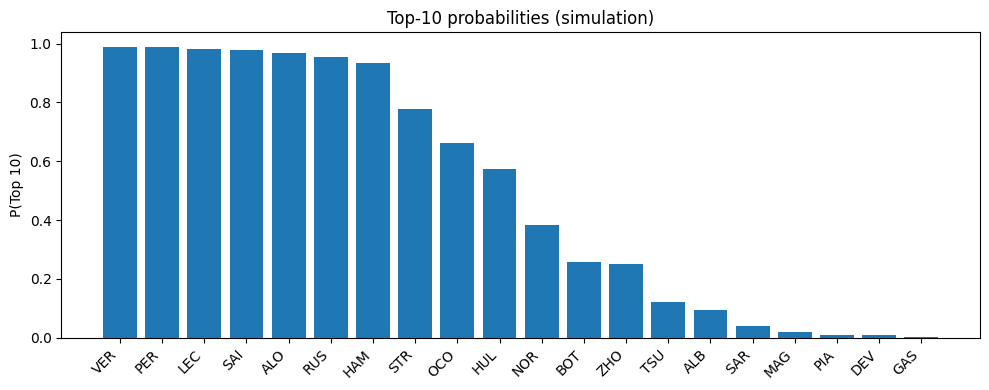

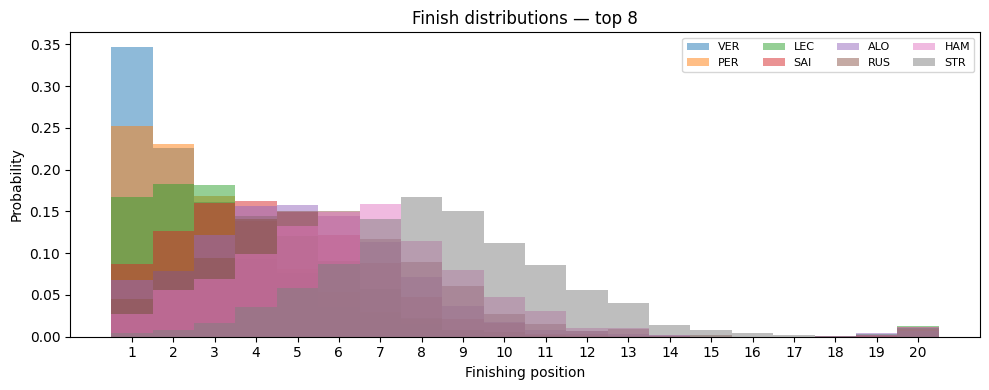

C:\Users\maxnd\AppData\Local\Temp\ipykernel_35668\1588666712.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top10, showfliers=False)


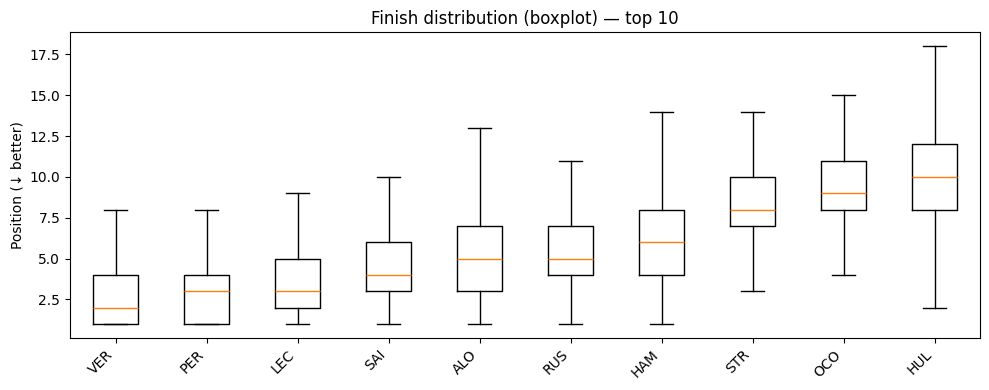

In [ ]:
# Goal: show a compact dashboard: expected order + probability bars + distributions.
# Why: quick insight into central tendency and uncertainty for key drivers.

import matplotlib.pyplot as plt
import numpy as np

tbl = sim_table.copy()

# 1) Expected finishing position (lower is better)
plt.figure(figsize=(10,4))
plt.bar(tbl["Driver"], tbl["exp_pos"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Expected finish (↓ better)")
plt.title(f"Expected finishing order — {YEAR} R{ROUND}")
plt.tight_layout(); plt.show()

# 2) Win probabilities
plt.figure(figsize=(10,4))
plt.bar(tbl["Driver"], tbl["p_win"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("P(Win)")
plt.title("Win probabilities"); plt.tight_layout(); plt.show()

# 3) Podium probabilities
plt.figure(figsize=(10,4))
plt.bar(tbl["Driver"], tbl["p_podium"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("P(Podium)")
plt.title("Podium probabilities"); plt.tight_layout(); plt.show()

# 4) Top-10 probabilities (simulation)
plt.figure(figsize=(10,4))
plt.bar(tbl["Driver"], tbl["p_top10_sim"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("P(Top 10)")
plt.title("Top-10 probabilities (simulation)"); plt.tight_layout(); plt.show()

# 5) Finish distributions — hist overlay for top 8
top8 = tbl.nsmallest(8, "exp_pos")["Driver"].tolist()
idxs = [drivers.index(d) for d in top8]
plt.figure(figsize=(10,4))
for i, d in enumerate(top8):
    arr = sims_pos[:, idxs[i]]
    plt.hist(arr, bins=np.arange(1,22)-0.5, alpha=0.5, label=d, density=True)
plt.xticks(range(1,21)); plt.xlabel("Finishing position"); plt.ylabel("Probability")
plt.title("Finish distributions — top 8"); plt.legend(ncols=4, fontsize=8)
plt.tight_layout(); plt.show()

# 6) Boxplot for top 10 finish distributions
top10 = tbl.nsmallest(10, "exp_pos")["Driver"].tolist()
idx10 = [drivers.index(d) for d in top10]
data  = [sims_pos[:, i] for i in idx10]
plt.figure(figsize=(10,4))
plt.boxplot(data, labels=top10, showfliers=False)
plt.xticks(rotation=45, ha="right"); plt.ylabel("Position (↓ better)")
plt.title("Finish distribution (boxplot) — top 10")
plt.tight_layout(); plt.show()

## One sampled finishing order (to get a concrete list)

- Goal: show one plausible finishing order from a single simulation run.
- This prints one sampled race result so you have a concrete finishing list.
- You can change s to see different sampled outcomes.

In [ ]:
# Goal: persist results and print one concrete finishing list.
# Why: makes it easy to pull into Streamlit and reports later.

from pathlib import Path

REPORTS = (Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()) / "reports"
REPORTS.mkdir(exist_ok=True)

# Summary CSV
out_csv = REPORTS / f"sim_{YEAR}_R{ROUND}_summary.csv"
sim_table.to_csv(out_csv, index=False)

# One sampled run
s = 0
order = np.argsort(sims_pos[s])
finish_list = [drivers[i] for i in order]
out_txt = REPORTS / f"sim_{YEAR}_R{ROUND}_sample_order.txt"
with open(out_txt, "w", encoding="utf-8") as f:
    for k, drv in enumerate(finish_list, start=1):
        f.write(f"{k}. {drv}\n")

print("Saved:", out_csv.name, "and", out_txt.name)
print("Sample finishing order:")
for k, drv in enumerate(finish_list, start=1):
    print(f"{k:2d}. {drv}")

Saved: sim_2023_R1_summary.csv and sim_2023_R1_sample_order.txt
Sample finishing order:
 1. VER
 2. SAI
 3. ALO
 4. PER
 5. LEC
 6. HAM
 7. RUS
 8. OCO
 9. STR
10. ALB
11. BOT
12. HUL
13. NOR
14. MAG
15. TSU
16. ZHO
17. SAR
18. DEV
19. GAS
20. PIA


## Mini track dashboard

## Load FP2 & (optionally) Race with telemetry/positions

- Goal: load FP2 (best for finding DRS zones) and Race for reference.
- Why: FP2 lets cars use DRS freely in DRS zones; positions give us a clean track trace.
- We load FP2 (for DRS) and the Race (optional) with telemetry/positions.
- If Race is slow/missing, FP2 alone is enough for the dashboard.

In [ ]:
import fastf1, logging
logging.getLogger("fastf1").setLevel(logging.WARNING)

def load_session_telemetry(year, rnd, code):
    s = fastf1.get_session(year, rnd, code)
    # Try modern flags; fall back gracefully so this runs on your FastF1 version.
    try:
        s.load(laps=True, telemetry=True, weather=False, messages=False)
    except TypeError:
        try:
            s.load(telemetry=True)
        except Exception:
            s.load()  # last resort (slower)
    return s

YEAR_FP, ROUND_FP = YEAR, ROUND   # match the weekend you simulated
fp2 = load_session_telemetry(YEAR_FP, ROUND_FP, "FP2")
try:
    race = load_session_telemetry(YEAR_FP, ROUND_FP, "R")
except Exception:
    race = None

print("Loaded:", f"FP2 laps={len(fp2.laps)}", "| Race loaded?" , race is not None)


req         WARNING 	DEFAULT CACHE ENABLED! (3.0 GB) C:\Users\maxnd\AppData\Local\Temp\fastf1


Loaded: FP2 laps=522 | Race loaded? True


## Base track line from one clean lap

- Goal: pick a clean reference lap and draw the track polyline.
- Why: gives us a base canvas to overlay DRS zones and markers.
- We grab the fastest FP2 lap for a front-runner and plot its (X,Y) path.
- This is our track outline for all overlays.

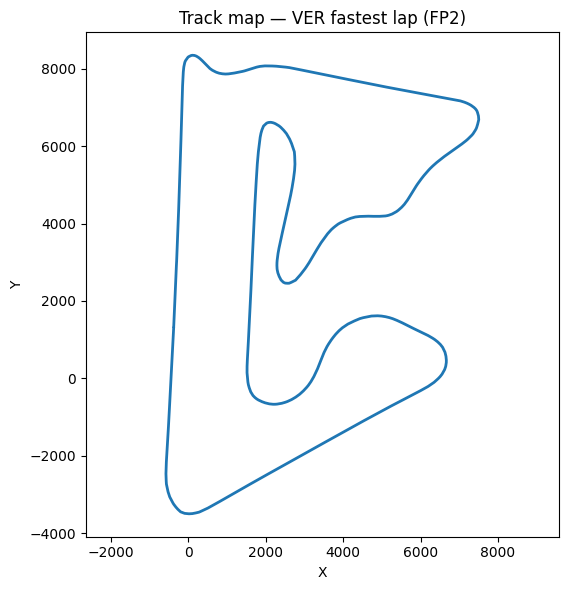

Reference driver: VER | telemetry points: 709


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# choose a reference driver with a valid telemetry lap
ref_driver = None
for cand in ["VER","LEC","HAM","PER","ALO","SAI","RUS"]:
    if (fp2.laps["Driver"] == cand).any():
        ref_driver = cand; break
if ref_driver is None:
    ref_driver = fp2.laps["Driver"].iloc[0]

ref_lap = fp2.laps.pick_drivers(ref_driver).pick_fastest()
tel_ref = ref_lap.get_telemetry()  # has X,Y,Distance,Speed,DRS (if available)

plt.figure(figsize=(6,6))
plt.plot(tel_ref["X"], tel_ref["Y"], linewidth=2)
plt.axis("equal"); plt.title(f"Track map — {ref_driver} fastest lap (FP2)")
plt.xlabel("X"); plt.ylabel("Y"); plt.tight_layout(); plt.show()

print("Reference driver:", ref_driver, "| telemetry points:", len(tel_ref))

## Approximate DRS zones from many FP2 laps

- Goal: infer DRS zones by looking where 'DRS' is active across many FP2 fastest laps.
- Why: sessions don't always ship DRS metadata; this heuristic is simple and works well.
- We find contiguous telemetry stretches where DRS>0 across many drivers and merge nearby segments.
- The result is a small table of start/end distances that approximates DRS activation zones.

In [ ]:
import numpy as np
import pandas as pd

def lap_drs_segments(lap):
    tel = lap.get_telemetry()
    if "DRS" not in tel.columns or "Distance" not in tel.columns:
        return []
    # treat any DRS > 0 as "active"
    active = tel["DRS"].fillna(0).astype(float) > 0
    if active.sum() == 0:
        return []
    # group consecutive True runs into segments by changes in state
    grp = (active != active.shift()).cumsum()
    segs = []
    for g, df in tel.groupby(grp):
        if not active.iloc[df.index[0]]:  # only True segments
            continue
        d0, d1 = df["Distance"].min(), df["Distance"].max()
        if d1 - d0 >= 80:  # filter out tiny blips; DRS zones are long
            segs.append((float(d0), float(d1)))
    return segs

# Collect segments from (up to) 12 drivers' fastest FP2 laps
drivers_fp2 = fp2.laps["Driver"].dropna().unique().tolist()[:12]
all_segs = []
for d in drivers_fp2:
    lap = fp2.laps.pick_drivers(d).pick_fastest()
    all_segs.extend(lap_drs_segments(lap))

# Merge/cluster segments that overlap or are close (<=120m gap)
all_segs = sorted(all_segs, key=lambda t: t[0])
merged = []
tol = 120.0
for s in all_segs:
    if not merged:
        merged.append(list(s))
    else:
        if s[0] <= merged[-1][1] + tol:  # overlaps or near
            merged[-1][1] = max(merged[-1][1], s[1])
        else:
            merged.append([s[0], s[1]])

# Make a small table (start/end in meters along lap)
drs_zones = pd.DataFrame(merged, columns=["start_m","end_m"])
drs_zones["length_m"] = (drs_zones["end_m"] - drs_zones["start_m"]).round(1)
drs_zones = drs_zones.sort_values("start_m").reset_index(drop=True)
print("Approx DRS zones inferred:", len(drs_zones))
drs_zones.head(10)

Approx DRS zones inferred: 1


,start_m,end_m,length_m
0,-0.008905,5388.246009,5388.3


## Draw DRS zones on the track + label zone starts

- Goal: overlay DRS zones on the track map and label zone starts (≈ detection/activation).
- Why: a visual check that our inferred zones sit on the straights as expected.
- We highlight each DRS segment on top of the track and annotate its start point.
- Starts ≈ activation markers; detection lines are usually just before them (this is a close proxy).

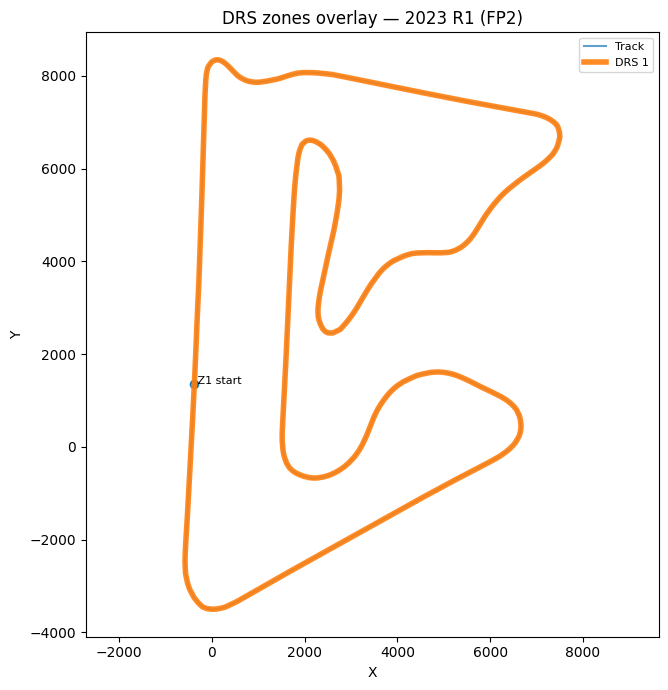

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# helper: take a distance window and slice the reference lap polyline
def slice_poly_by_distance(tel, d0, d1):
    mask = (tel["Distance"] >= d0) & (tel["Distance"] <= d1)
    return tel.loc[mask, ["X","Y"]]

plt.figure(figsize=(7,7))
plt.plot(tel_ref["X"], tel_ref["Y"], linewidth=1.5, alpha=0.7, label="Track")

# overlay each zone
for i, row in drs_zones.iterrows():
    seg = slice_poly_by_distance(tel_ref, row.start_m, row.end_m)
    if len(seg) >= 2:
        plt.plot(seg["X"], seg["Y"], linewidth=4, alpha=0.9, label=f"DRS {i+1}")

        # mark zone start with a dot + text
        start_idx = (tel_ref["Distance"] - row.start_m).abs().idxmin()
        xs, ys = tel_ref.loc[start_idx, ["X","Y"]]
        plt.scatter([xs],[ys], s=35)
        plt.text(xs, ys, f" Z{i+1} start", fontsize=8)

plt.axis("equal"); plt.title(f"DRS zones overlay — {YEAR_FP} R{ROUND_FP} (FP2)")
plt.xlabel("X"); plt.ylabel("Y"); plt.legend(fontsize=8)
plt.tight_layout(); plt.show()


## Speed trap + heavy-braking hotspots

- Goal: mark the fastest point (speed trap proxy) and top 3 heavy-braking spots.
- Why: more insight for the dashboard—where’s the big stop and max speed?
- We annotate the max-speed point and top 3 braking hotspots using simple gradients.
- It’s a quick, readable proxy for where drivers hit Vmax and stop hardest.

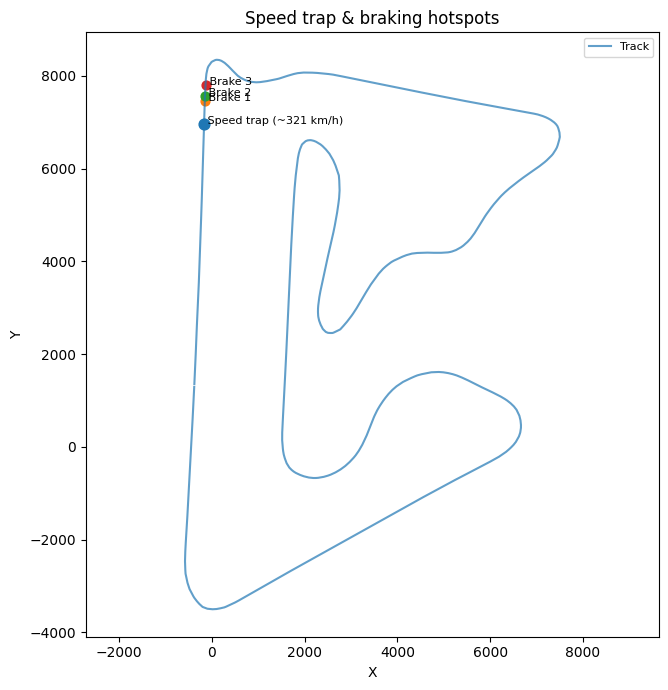

In [ ]:
# Goal: mark the fastest point (speed trap proxy) and top 3 heavy-braking spots.
# Why: more insight for the dashboard—where’s the big stop and max speed?

import numpy as np

tel = tel_ref.copy()
# "speed trap": max speed point on the lap
idx_vmax = tel["Speed"].idxmax() if "Speed" in tel.columns else tel.index[0]
xv, yv, v = tel.loc[idx_vmax, ["X","Y","Speed"]]

# heavy braking: largest negative dSpeed/dDistance peaks
if {"Speed","Distance"}.issubset(tel.columns):
    dV = np.gradient(tel["Speed"].values)
    dD = np.gradient(tel["Distance"].values)
    decel = dV / np.clip(dD, 1e-6, None)  # units ~ (km/h) per meter
    # big negative values → heavy braking; take 3 strongest
    k = min(3, len(decel))
    idx_brake = np.argsort(decel)[:k]  # most negative
else:
    idx_brake = []

plt.figure(figsize=(7,7))
plt.plot(tel["X"], tel["Y"], linewidth=1.5, alpha=0.7, label="Track")

# speed trap marker
plt.scatter([xv],[yv], s=60)
plt.text(xv, yv, f" Speed trap (~{int(v)} km/h)", fontsize=8)

# braking markers
for j, i in enumerate(idx_brake, start=1):
    xb, yb = tel.loc[tel.index[i], ["X","Y"]]
    plt.scatter([xb],[yb], s=40)
    plt.text(xb, yb, f" Brake {j}", fontsize=8)

plt.axis("equal"); plt.title("Speed trap & braking hotspots")
plt.xlabel("X"); plt.ylabel("Y"); plt.legend(fontsize=8)
plt.tight_layout(); plt.show()

## Save dashboard assets (CSV + PNGs)

- Goal: persist a tiny DRS table + two figures to /reports for reuse.
- Why: useful for the Streamlit app (we’ll add buttons to load these).
- You now have a DRS zones CSV and two PNGs saved to /reports for reuse.
- We’ll wire these into Streamlit in Phase 5 under “Weekend overview”.

In [ ]:
# Goal: persist a tiny DRS table + two figures to /reports for reuse.
# Why: useful for the Streamlit app (we’ll add buttons to load these).

from pathlib import Path
REPORTS = (Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()) / "reports"
REPORTS.mkdir(exist_ok=True)

# Save DRS zones table
drs_csv = REPORTS / f"drs_zones_{YEAR_FP}_R{ROUND_FP}.csv"
drs_zones.round(1).to_csv(drs_csv, index=False)

# Save two quick figures again to files
import matplotlib.pyplot as plt

# DRS overlay figure
plt.figure(figsize=(7,7))
plt.plot(tel_ref["X"], tel_ref["Y"], linewidth=1.5, alpha=0.7)
for i, row in drs_zones.iterrows():
    seg = tel_ref[(tel_ref["Distance"]>=row.start_m)&(tel_ref["Distance"]<=row.end_m)]
    if len(seg) >= 2: plt.plot(seg["X"], seg["Y"], linewidth=4, alpha=0.9)
plt.axis("equal"); plt.title(f"DRS zones — {YEAR_FP} R{ROUND_FP}")
plt.tight_layout()
fig1 = REPORTS / f"drs_overlay_{YEAR_FP}_R{ROUND_FP}.png"
plt.savefig(fig1, dpi=160); plt.close()

# Speed trap + braking figure
plt.figure(figsize=(7,7))
plt.plot(tel_ref["X"], tel_ref["Y"], linewidth=1.5, alpha=0.7)
plt.scatter([xv],[yv], s=60); plt.text(xv, yv, " Speed trap", fontsize=8)
for j, i in enumerate(idx_brake, start=1):
    xb, yb = tel_ref.loc[tel_ref.index[i], ["X","Y"]]
    plt.scatter([xb],[yb], s=40); plt.text(xb, yb, f" Brake {j}", fontsize=8)
plt.axis("equal"); plt.title("Speed trap & braking")
plt.tight_layout()
fig2 = REPORTS / f"trap_brake_{YEAR_FP}_R{ROUND_FP}.png"
plt.savefig(fig2, dpi=160); plt.close()

print("Saved:", drs_csv.name, "|", fig1.name, "|", fig2.name)

Saved: drs_zones_2023_R1.csv | drs_overlay_2023_R1.png | trap_brake_2023_R1.png
